In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/alex/Desktop/Columbia/Algorithms/Project_3/new_file_2015.csv', index_col="Unnamed: 0", keep_default_na=False)

In [3]:
#"emp_length" can be < 1 year or > 10 years
df.emp_length = df.emp_length.str.replace("+","").str.replace(" years","").str.replace("< ","").str.replace(" year","")

In [4]:
del df['desc']

In [5]:
df.dtypes

loan_status                object
addr_state                 object
annual_inc                float64
emp_title                  object
emp_length                 object
home_ownership             object
zip_code                   object
purpose                    object
earliest_cr_line           object
pub_rec                     int64
mths_since_last_delinq     object
status                     object
dtype: object

In [6]:
df.zip_code = df.zip_code.str.replace("xx","")

In [7]:
df.loc[df.emp_length.str.contains("n/a"), "emp_length"] = np.nan

In [8]:
quart1 = df.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')["annual_inc"]
quart2 = df.quantile(q=0.5, axis=0, numeric_only=True, interpolation='linear')["annual_inc"]
quart3 = df.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')["annual_inc"]
print(quart1,quart2,quart3,df["annual_inc"].max())

46000.0 65000.0 91690.5 9500000.0


In [9]:
df["quartile"] = pd.cut(df["annual_inc"], [0,quart1,quart2,quart3,df["annual_inc"].max()], right=True, labels=[0,quart1,quart2,quart3])

In [10]:
df["emp_length"]= df["emp_length"].dropna().astype(int)

In [11]:
df["emp_length_short"] = pd.cut(df["emp_length"], [0,1,5,9,10,11], right=True, labels=[0,1,5,9,10])

In [12]:
df[df.status=="problem"].groupby("quartile").status.count() / df.groupby("quartile").status.count()

quartile
0.0        0.151174
46000.0    0.134514
65000.0    0.120162
91690.5    0.099293
Name: status, dtype: float64

addr_state
SD    16.526946
NV    15.732613
AL    15.522723
NH     8.001940
VT     7.623318
ME     6.717850
Name: status, dtype: float64


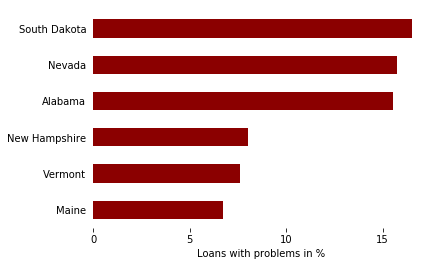

In [13]:
state_prob = (df[df.status=="problem"].groupby("addr_state").status.count() / df.groupby("addr_state").status.count() * 100)
state_prob = state_prob.sort_values(ascending=False)
state_prob = state_prob[state_prob.isin(state_prob.head(3)) | state_prob.isin(state_prob.tail(3))]
print(state_prob)
ax = state_prob.sort_values().plot(kind="barh",color="darkred")
ax.set_xticks([0,5,10,15])
ax.tick_params(left="off")
ax.set_ylabel("")
ax.set_yticklabels(['Maine','Vermont','New Hampshire','Alabama','Nevada','South Dakota'])
ax.set_xlabel("Loans with problems in %")

for item in ['top','right','bottom','left']:
    ax.spines[item].set_visible(False)

ax.get_figure().savefig("states.svg")

In [14]:
emp_prob = df[df.status=="problem"].groupby("emp_length_short").status.count() / df.groupby("emp_length_short").status.count()
emp_prob.sort_values(ascending=False)

emp_length_short
0     0.136007
1     0.128004
5     0.127057
9     0.114739
10         NaN
Name: status, dtype: float64

In [15]:
# first two numbers of zip code
df["zip_short"] = df.zip_code.str[:1]

In [16]:
zip_prob = df[df.status=="problem"].groupby(df.zip_short).status.count() / df.groupby(df.zip_short).status.count()
zip_prob.sort_values(ascending=False)

zip_short
1    0.135145
7    0.131878
3    0.131049
4    0.129826
8    0.128671
2    0.124407
9    0.124021
5    0.119551
6    0.114951
0    0.114673
Name: status, dtype: float64

In [17]:
df.purpose.value_counts()

debt_consolidation    250020
credit_card           102025
home_improvement       25293
other                  19204
major_purchase          7449
medical                 3938
car                     3466
small_business          3364
moving                  2420
vacation                2249
house                   1438
renewable_energy         224
wedding                    4
educational                1
Name: purpose, dtype: int64

In [18]:
df["purpose_new"] = df.purpose

In [19]:
df.loc[df.purpose.isin(["medical","car","small_business","moving","vacation","house","renewable_energy",
                    "wedding","educational"]),"purpose_new"] = "other"

In [20]:
df.purpose_new.value_counts()

debt_consolidation    250020
credit_card           102025
other                  36308
home_improvement       25293
major_purchase          7449
Name: purpose_new, dtype: int64

In [36]:
grouped_count = df.groupby(["zip_short","quartile","purpose_new"]).status.count()
grouped_problem = df[df.status=="problem"].groupby(["zip_short","quartile","purpose_new"]).status.count()
(grouped_problem[grouped_problem>5]/grouped_count).dropna().sort_values(ascending=False)

zip_short  quartile  purpose_new       
5          0.0       home_improvement      0.191860
8          46000.0   major_purchase        0.191489
5          0.0       other                 0.190588
8          0.0       major_purchase        0.190141
1          0.0       major_purchase        0.181070
3          65000.0   other                 0.168388
           0.0       debt_consolidation    0.168103
1          0.0       debt_consolidation    0.167864
4          0.0       other                 0.166192
8          0.0       debt_consolidation    0.164373
3          65000.0   major_purchase        0.162791
4          0.0       debt_consolidation    0.162134
2          46000.0   other                 0.161747
           0.0       other                 0.161034
7          46000.0   major_purchase        0.160643
3          46000.0   other                 0.160618
8          0.0       other                 0.160567
7          0.0       debt_consolidation    0.160295
9          0.0       deb

In [22]:
df["credit_year"] = df.earliest_cr_line.str[4:].astype(int)

In [23]:
df["years_credit"] = pd.cut(2017-df["credit_year"], [0,10,15,20,2017-df["credit_year"].min()], right=True, labels=[0,10,15,20])

In [24]:
df["years_credit"] = df["years_credit"].astype(int)

In [25]:
grouped_count = df.groupby(["employment_length","","zip_short","quartile","purpose_new","years_credit"]).status.count()
grouped_problem = df[df.status=="problem"].groupby(["zip_short","quartile","purpose_new","years_credit"]).status.count()
(grouped_problem[grouped_problem>5]/grouped_count).dropna().sort_values(ascending=False)

zip_short  quartile  purpose_new       years_credit
5          0.0       home_improvement  10              0.301887
0          46000.0   home_improvement  0               0.292683
3          65000.0   other             0               0.267442
8          91690.5   other             10              0.258621
3          65000.0   home_improvement  0               0.250000
6          65000.0   other             0               0.240000
8          0.0       major_purchase    0               0.235294
1          0.0       major_purchase    10              0.234375
9          65000.0   home_improvement  0               0.230769
4          46000.0   other             0               0.222222
7          0.0       major_purchase    15              0.222222
9          91690.5   major_purchase    0               0.218750
5          0.0       other             0               0.216867
4          65000.0   other             15              0.216049
8          46000.0   major_purchase    20           

In [26]:
years_credit_problem = df[df.status=="problem"]["years_credit"].value_counts()
years_credit_count = df.groupby(df.years_credit).status.count()
(years_credit_problem[years_credit_problem>5] / years_credit_count)

0     0.151756
10    0.142984
15    0.123328
20    0.107917
dtype: float64

In [41]:
grouped_count = df.groupby(["emp_length_short","years_credit","zip_short","quartile","purpose_new"]).status.count()
grouped_problem = df[df.status=="problem"].groupby(["emp_length_short","years_credit","zip_short","quartile","purpose_new"]).status.count()

credit_card            9.888753
home_improvement      11.524928
major_purchase        12.820513
debt_consolidation    13.621710
other                 14.456869
Name: purpose_new, dtype: float64


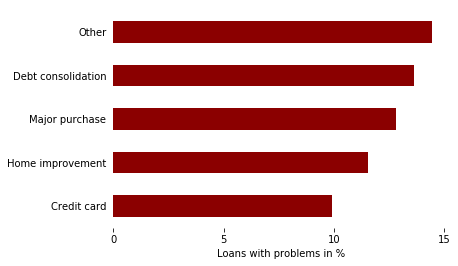

In [28]:
count = df.purpose_new.value_counts()
problem = df[df.status=="problem"].purpose_new.value_counts()

print((problem/count*100).sort_values())

ax = (problem/count*100).sort_values().plot(kind="barh", color="darkred")

for item in ['top','right','bottom','left']:
    ax.spines[item].set_visible(False)

ax.set_xticks([0,5,10,15])
ax.set_yticklabels(['Credit card','Home improvement','Major purchase','Debt consolidation','Other'])
ax.set_xlabel("Loans with problems in %")
ax.tick_params(left="off")

fig = ax.get_figure()
fig.savefig("purpose.svg")

91690.5     9.929327
65000.0    12.016152
46000.0    13.451423
0.0        15.117383
Name: quartile, dtype: float64


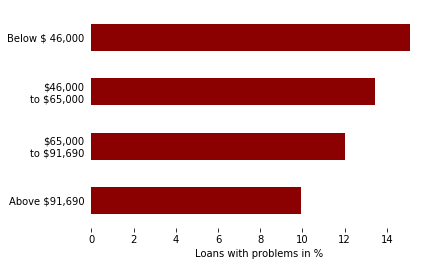

In [29]:
count = df.quartile.value_counts()
problem = df[df.status=="problem"].quartile.value_counts()

print((problem/count*100).sort_values())

ax = (problem/count*100).sort_values().plot(kind="barh", color="darkred")
fig = ax.get_figure()

for item in ['top','right','bottom','left']:
    ax.spines[item].set_visible(False)
    
ax.tick_params(left="off")
ax.set_xlabel("Loans with problems in %")    


ax.set_yticklabels(['Above $91,690','$65,000\nto $91,690','$46,000\nto $65,000','Below $ 46,000'])

fig.savefig("quartile.svg")

0    11.467348
6    11.495061
5    11.955090
9    12.402118
2    12.440713
8    12.867074
4    12.982616
3    13.104929
7    13.187797
1    13.514540
Name: zip_short, dtype: float64


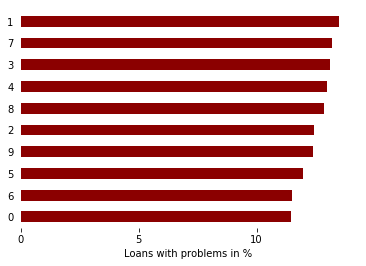

In [30]:
count = df.zip_short.value_counts()
problem = df[df.status=="problem"].zip_short.value_counts()

print((problem/count*100).sort_values())

ax = (problem/count*100).sort_values().plot(kind="barh", color="darkred")
fig = ax.get_figure()
ax.set_xticks([0,5,10])

for item in ['top','right','bottom','left']:
    ax.spines[item].set_visible(False)
    
ax.tick_params(left="off")
ax.set_xlabel("Loans with problems in %")    

fig.savefig("zip_short.svg")

20    10.791681
15    12.332812
10    14.298439
0     15.175593
Name: years_credit, dtype: float64


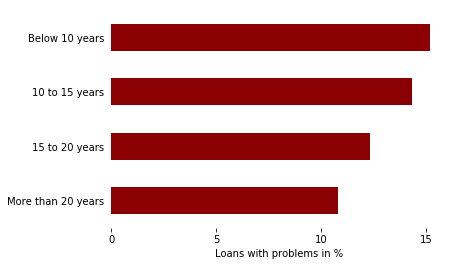

In [31]:
count = df.years_credit.value_counts()
problem = df[df.status=="problem"].years_credit.value_counts()

print((problem/count*100).sort_values())

ax = (problem/count*100).sort_values().plot(kind="barh", color="darkred")
fig = ax.get_figure()

for item in ['top','right','bottom','left']:
    ax.spines[item].set_visible(False)
    
ax.tick_params(left="off")
ax.set_xlabel("Loans with problems in %") 
ax.set_xticks([0,5,10,15])

ax.set_yticklabels(['More than 20 years','15 to 20 years','10 to 15 years','Below 10 years'])

fig.savefig("years_credit.svg")

9     11.473916
5     12.705726
1     12.800445
0     13.600699
10          NaN
Name: emp_length_short, dtype: float64


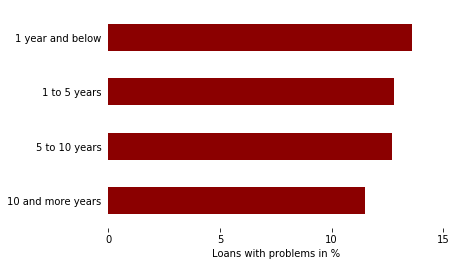

In [32]:
count = df[df.emp_length_short < 10 ].emp_length_short.value_counts()
problem = df[(df.status=="problem") & (df.emp_length_short < 10) ].emp_length_short.value_counts()

print((problem/count*100).sort_values())

ax = (problem/count*100).sort_values().head(4).plot(kind="barh", color="darkred")
fig = ax.get_figure()

for item in ['top','right','bottom','left']:
    ax.spines[item].set_visible(False)
    
ax.tick_params(left="off")
ax.set_xlabel("Loans with problems in %") 
ax.set_xticks([0,5,10,15])

ax.set_yticklabels(['10 and more years','5 to 10 years','1 to 5 years','1 year and below'])

fig.savefig("emp_length_short.svg")

In [52]:
count_dict = dict(grouped_count[grouped_count>100])
rate_dict = dict(grouped_problem[grouped_count>100]/grouped_count[grouped_count>100])

In [53]:
df_group = pd.DataFrame()
new_employee_length = []
new_years_credit = []
new_zip_short = []
new_quartile = []
new_purpose = []
new_rate = []
new_count = []


for key, value in count_dict.items():
    new_employee_length.append(key[0])
    new_years_credit.append(key[1])
    new_zip_short.append(key[2])
    new_quartile.append(key[3])
    new_purpose.append(key[4])
    new_count.append(value)

for key, value in rate_dict.items():
    new_rate.append(value)

df_group['employee_length'] = new_employee_length
df_group['years_credit'] = new_years_credit
df_group['zip'] = new_zip_short
df_group['quartile'] = new_quartile
df_group['purpose'] = new_purpose
df_group['rate'] = new_rate
df_group['count'] = new_count

In [54]:
df_group = df_group.dropna().sort_values(by='rate',ascending=False)

In [55]:
df_group.purpose.value_counts()

debt_consolidation    530
credit_card           394
other                  74
home_improvement       44
Name: purpose, dtype: int64

In [ ]:
df_group.to_csv("grouped_data.csv")